## Семинар 2 "Распознавание рукописных цифр"

ФИО: Ковалишин Никита Игоревич

Группа ML-22

В этом задании мы используем нейронную сеть для распознавания рукописных цифр (MNIST). Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации.

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
#from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # All these classes are implemented further
from IPython.display import clear_output
%matplotlib inline

In [ ]:
def GetColumnSliceByVector(matr, vec):
  offsets = np.arange(0, matr.shape[0] * matr.shape[1], matr.shape[1])
  return matr.reshape(matr.size)[vec + offsets]

############ Linear ############
# | |                        | |
# | |                        | |
#\   /                      \   /
# \ /                        \ /

class Linear:

  def __init__(self, currDim, nextDim):
    self.weights = 0.5 - np.random.random((currDim, nextDim))
    self.b = np.zeros(nextDim)
    self.gradb = 0
    self.gradW = 0

  def forward(self, X):
    self.X = X
    return np.dot(X, self.weights) + self.b

  def backward(self, dLdy):
    dLdx = np.dot(dLdy, self.weights.transpose(1, 0)) #i x n и m x n -> i x m x n
    self.gradb = np.sum(dLdy, axis = 0)
    dLdy = dLdy.reshape(dLdy.shape[0], 1, dLdy.shape[1])
    self.gradW = np.sum(np.matmul(self.X.reshape(self.X.shape[0], self.X.shape[1], 1), dLdy), axis = 0)
    return dLdx

  def step(self, learning_rate):
    self.weights -= learning_rate * self.gradW
    self.b -= learning_rate * self.gradb

########### NLL Loss ###########
# | |                        | |
# | |                        | |
#\   /                      \   /
# \ /                        \ /

class NLLLoss:

  def __init__(self):
    pass

  def forward(self, probs, y): # y - это вектор истинных классов для каждого элемента батча
    self.probs = probs
    self.y = y
    return np.mean(-np.log(GetColumnSliceByVector(probs, y)))

  def backward(self):
    #under it's calculated the derivative of NLL Loss with partial fraction reduction
    dSdxOut = -self.probs.reshape(self.probs.size) #derivative of softmax AFTER fraction reduction
    offsets = np.arange(0, self.probs.shape[0] * self.probs.shape[1], self.probs.shape[1]) # offsets for true classes indexing
    dSdxOut[offsets + self.y] = 1 - GetColumnSliceByVector(self.probs, self.y)
    return -dSdxOut.reshape(self.probs.shape[0], self.probs.shape[1]) / self.probs.shape[0] #minus from loss before np.log

######## Neural Network ########
# | |                        | |
# | |                        | |
#\   /                      \   /
# \ /                        \ /

class NeuralNetwork: #classification network. By default there is added softmax layer in the end.

  def __init__(self, layersLst):
    self.layersLst = layersLst

  def SoftMax(self, X):
    X = np.float128(X)
    self.X = X
    return np.exp(X) / np.sum(np.exp(X), axis = 1).reshape(X.shape[0], 1)

  def forward(self, X):
    xTransit = X
    for layer in self.layersLst:
      xTransit = layer.forward(xTransit)
    return self.SoftMax(xTransit)

  def backward(self, dLdy):
    dLdx = dLdy
    for layer in reversed(self.layersLst):
      dLdx = layer.backward(dLdx)
    return dLdx

  def step(self, learning_rate):
    for layer in self.layersLst:
      layer.step(learning_rate)

In [ ]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

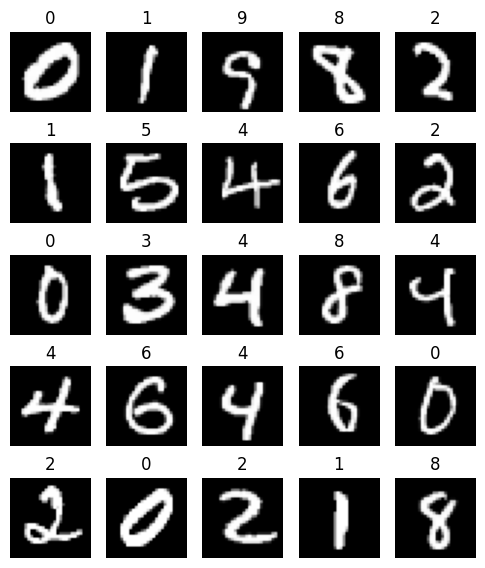

In [ ]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [ ]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [ ]:
def StableSigmoid(x): #Sigmoid without overflow
  return 1 / (1 + np.exp(-x * (x > 0))) * (x >= 0) + \
         np.exp(x * (x < 0)) / (1 + np.exp(x * (x < 0))) * (x < 0)

class Sigmoid:
  def __init__(self):
    pass

  def forward(self, X):
    self.X = X
    return StableSigmoid(X)

  def backward(self, dLdy):
    return StableSigmoid(self.X)*(1 - StableSigmoid(self.X))*dLdy#45634

  def step(self, learning_rate):
    pass

In [ ]:
networkSgmd = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 2
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])

Epoch 19... (Train/Test) NLL: 0.221/0.235	Accuracy: 0.936/0.929

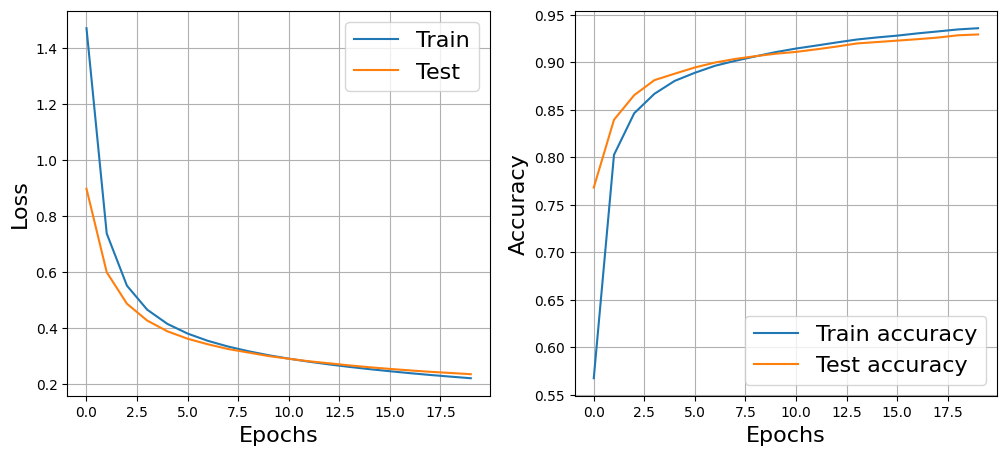

In [ ]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(networkSgmd, 20, 0.01, loss=NLLLoss())

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [ ]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

In [ ]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''

    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.080/0.184	Accuracy: 0.975/0.953

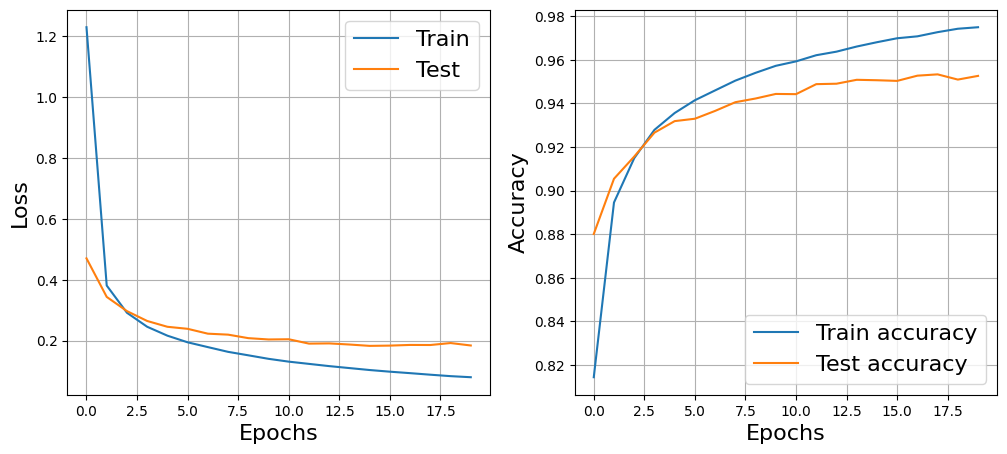

In [ ]:
networkReLU = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
tr_r, ts_r, tr_ac_r, ts_ac_r = train(networkReLU, 20, 0.01, plot=True, verbose=True, loss=NLLLoss())

Epoch 19... (Train/Test) NLL: 0.071/0.192	Accuracy: 0.978/0.951

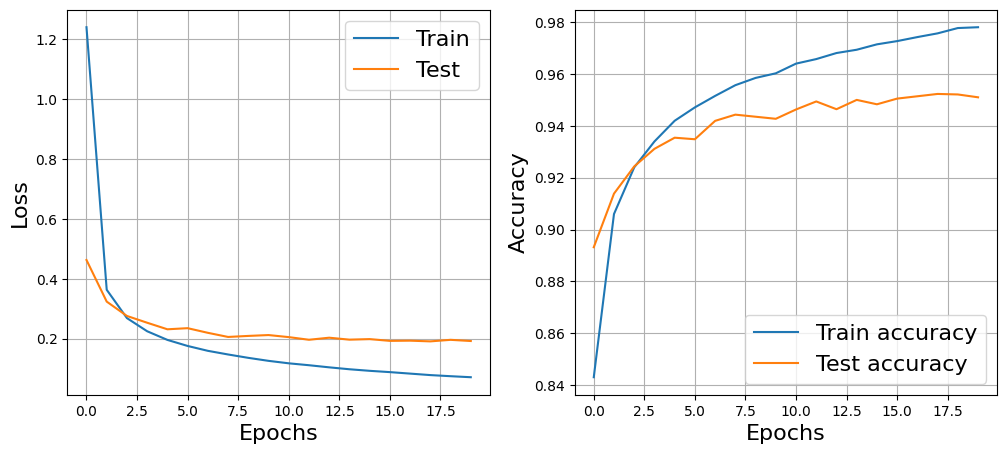

In [ ]:
networkELU = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
tr_e, ts_e, tr_ac_e, ts_ac_e = train(networkELU, 20, 0.01, plot=True, verbose=True, loss=NLLLoss())

### HW1 (1 балл): Реализовать Tanh

In [ ]:
class Tanh:
  def __init__(self):
    pass

  def forward(self, X):
    self.X = X
    return np.tanh(self.X)

  def backward(self, dLdy):
    return (1 - np.tanh(self.X)**2) * dLdy

  def step(self, learning_rate):
    pass

Epoch 19... (Train/Test) NLL: 0.140/0.256	Accuracy: 0.961/0.922

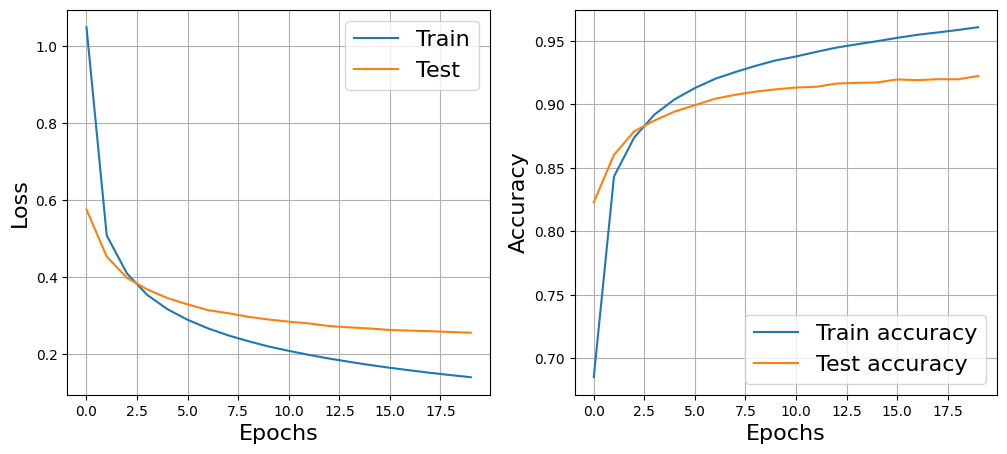

In [ ]:
networkTanh = NeuralNetwork([Linear(784, 100), Tanh(),
                             Linear(100, 100), Tanh(),
                             Linear(100, 10)])
tr_t, ts_t, tr_ac_t, ts_ac_t = train(networkTanh, 20, 0.01, plot=True, verbose=True, loss=NLLLoss())

###Сравнение Tanh с другими активациями

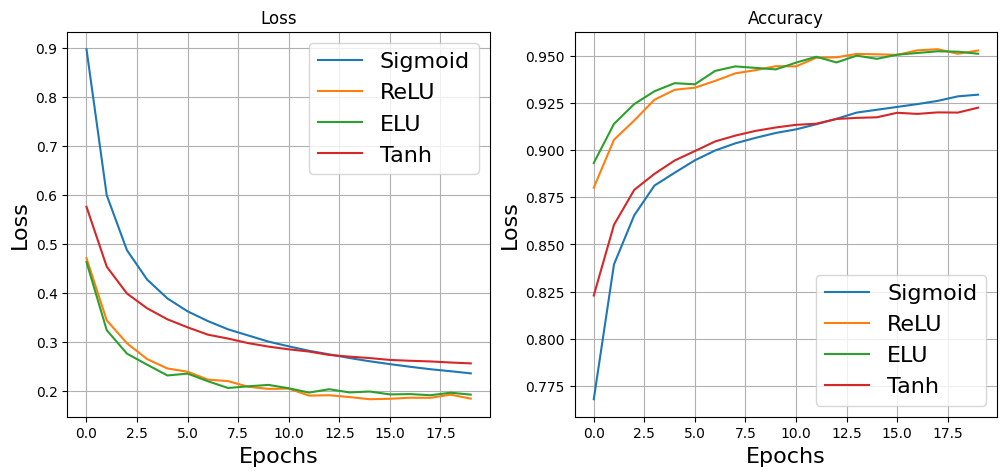

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.plot(ts_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.plot(ts_ac_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Часть 3: Анализ ошибок

In [ ]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = networkTanh.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)#456
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

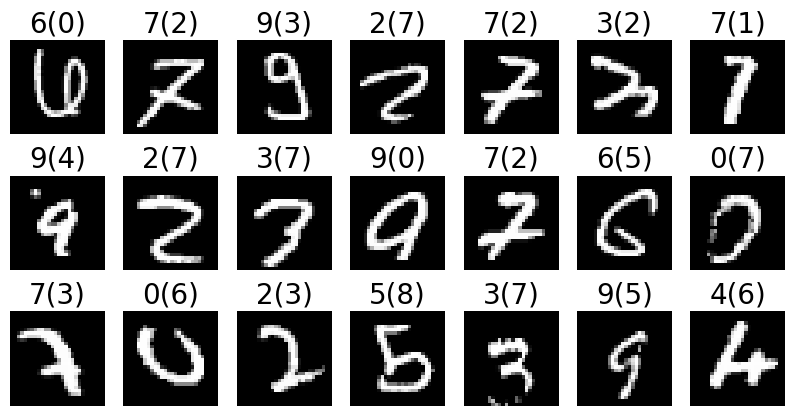

In [ ]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

###Повороты на +15 и -15 градусов.

Визуализация поворота:

(-0.5, 27.5, 27.5, -0.5)

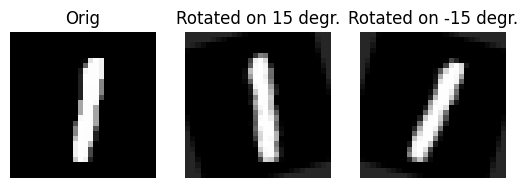

In [ ]:
from skimage.transform import rotate

img = X[0].reshape(28, 28)
plt.subplot(1, 3, 1)
plt.imshow(img, cmap=plt.cm.Greys_r)
plt.title('Orig')
plt.axis('off')
img15Rot = rotate(img, 15)
plt.subplot(1, 3, 2)
plt.imshow(img15Rot, cmap=plt.cm.Greys_r)
plt.title('Rotated on 15 degr.')
plt.axis('off')
img_15Rot = rotate(img, -15)
plt.subplot(1, 3, 3)
plt.imshow(img_15Rot, cmap=plt.cm.Greys_r)
plt.title('Rotated on -15 degr.')
plt.axis('off')

Добавляем повёрнутые на ±15 градусов изображения к исходному тренировочному датасету:

In [ ]:
from torch import from_numpy, empty_like, cat
from torch.utils.data import TensorDataset

train_loaderfull = DataLoader(train_dataset, batch_size=train_dataset.data.shape[0], shuffle=False)
tplXYTr = next(iter(train_loaderfull)) #tuple(X_train, y_train)
Rotated15XYTr = (empty_like(tplXYTr[0]), tplXYTr[1])
Rotated_15XYTr = (empty_like(tplXYTr[0]), tplXYTr[1])
for i, feature in enumerate(tplXYTr[0]):
  Rotated15XYTr[0][i] = from_numpy(rotate(feature.reshape(28, 28).numpy(), 15).reshape(1, 28, 28))
  Rotated_15XYTr[0][i] = from_numpy(rotate(feature.reshape(28, 28).numpy(), -15).reshape(1, 28, 28))

XTrWthRotate = cat((tplXYTr[0], Rotated15XYTr[0], Rotated_15XYTr[0]), 0)
YTrWthRotate = cat((tplXYTr[1], Rotated15XYTr[1], Rotated_15XYTr[1]), 0)

train_datasetRotated = TensorDataset(XTrWthRotate, YTrWthRotate)
train_loader = DataLoader(train_datasetRotated, batch_size=32, shuffle=True)

Обучаемся на новом датасете с добавлением только изображений, повёрнутых на ±15 градусов:

Epoch 19... (Train/Test) NLL: 0.123/0.166	Accuracy: 0.964/0.949

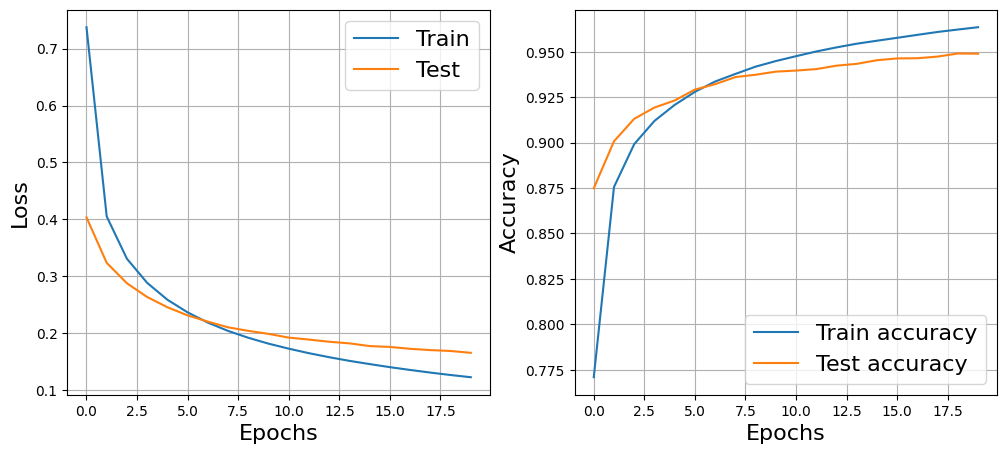

In [ ]:
networkTanh = NeuralNetwork([Linear(784, 100), Tanh(),
                             Linear(100, 100), Tanh(),
                             Linear(100, 10)])
tr_rot_t, ts_rot_t, tr_rot_ac_t, ts_rot_ac_t = train(networkTanh, 20, 0.01, plot=True, verbose=True, loss=NLLLoss())

###Случайные сдвиги

Визуализация сдвига:

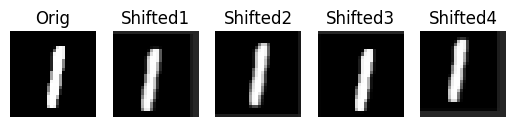

In [ ]:
from skimage.transform import SimilarityTransform, warp

def RandomShift(image):
  transform = SimilarityTransform(translation=tuple(3*(1 - 2*np.random.random(2))))
  return np.float32(warp(image, transform))

plt.subplot(1, 5, 1)
plt.imshow(img, cmap=plt.cm.Greys_r)
plt.title("Orig")
plt.axis("off")
for i in range(1, 5):
  plt.subplot(1, 5, i+1)
  plt.imshow(RandomShift(img), cmap=plt.cm.Greys_r)
  plt.title(f"Shifted{i}")
  plt.axis("off")

Добавляем сдвинутые случайным образом изображения к исходному тренировочному датасету:

In [ ]:
shiftedXYTr = (empty_like(tplXYTr[0]), tplXYTr[1])
for i, feature in enumerate(tplXYTr[0]):
  shiftedXYTr[0][i] = from_numpy(RandomShift(feature.reshape(28, 28).numpy()))

XTrWthRndShift = cat((tplXYTr[0], shiftedXYTr[0]), 0)
YTrWthRndShift = cat((tplXYTr[1], shiftedXYTr[1]), 0)

train_datasetWthShft = TensorDataset(XTrWthRndShift, YTrWthRndShift)
train_loader = DataLoader(train_datasetWthShft, batch_size=32, shuffle=True)

Обучаемся на датасете с добавлением только изображений со случайными сдвигами:

Epoch 19... (Train/Test) NLL: 0.205/0.182	Accuracy: 0.938/0.940

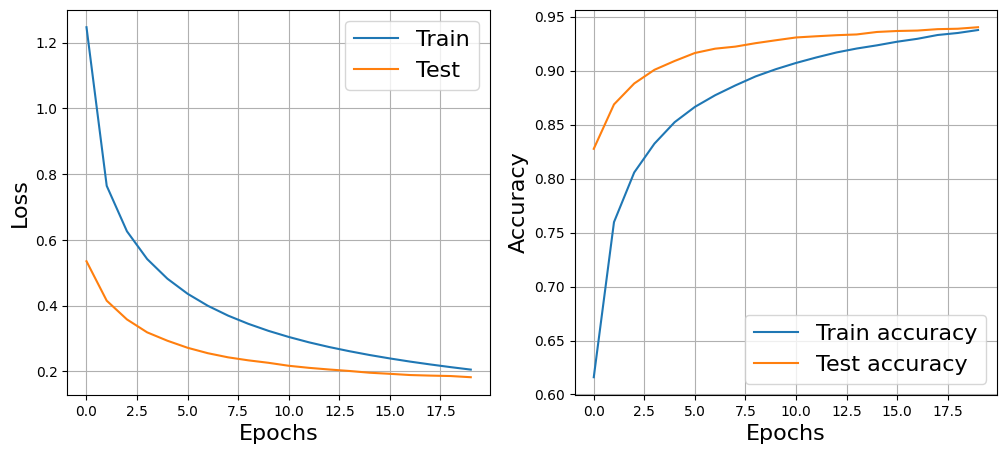

In [ ]:
networkTanh = NeuralNetwork([Linear(784, 100), Tanh(),
                             Linear(100, 100), Tanh(),
                             Linear(100, 10)])
tr_shft_t, ts_shft_t, tr_shft_ac_t, ts_shft_ac_t = train(networkTanh, 20, 0.01, plot=True, verbose=True, loss=NLLLoss())

###Шум

 Визуализация шума:

(-0.5, 27.5, 27.5, -0.5)

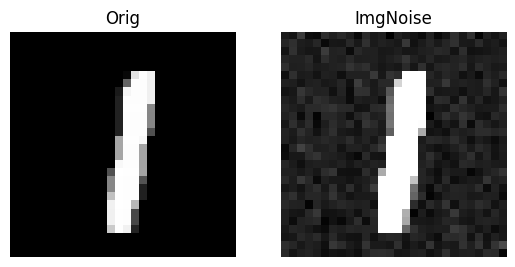

In [ ]:
from skimage.util import random_noise#353
plt.subplot(1, 2, 1)#345
plt.imshow(img, cmap=plt.cm.Greys_r)
plt.title('Orig')
plt.axis('off')
imgNoise = random_noise(img, var=0.003)
plt.subplot(1, 2, 2)
plt.imshow(imgNoise, cmap=plt.cm.Greys_r)
plt.title('ImgNoise')
plt.axis('off')

Добавление к исходному тренировочному датасету зашумлённых изображений:

In [ ]:
from skimage.util import random_noise

noisedXYTr = (empty_like(tplXYTr[0]), tplXYTr[1])

for i, feature in enumerate(tplXYTr[0]):
  noisedXYTr[0][i] = from_numpy(random_noise(feature.reshape(28, 28).numpy()).reshape(1, 28, 28))

XTrWthNoise = cat((tplXYTr[0], noisedXYTr[0]), 0)
YTrWthNoise = cat((tplXYTr[1], noisedXYTr[1]), 0)

train_datasetWthNoise = TensorDataset(XTrWthNoise, YTrWthNoise)
train_loader = DataLoader(train_datasetWthNoise, batch_size=32, shuffle=True)

Обучаемся на датасете с добавлением только зашумлённых изображений:

Epoch 19... (Train/Test) NLL: 0.106/0.187	Accuracy: 0.969/0.943

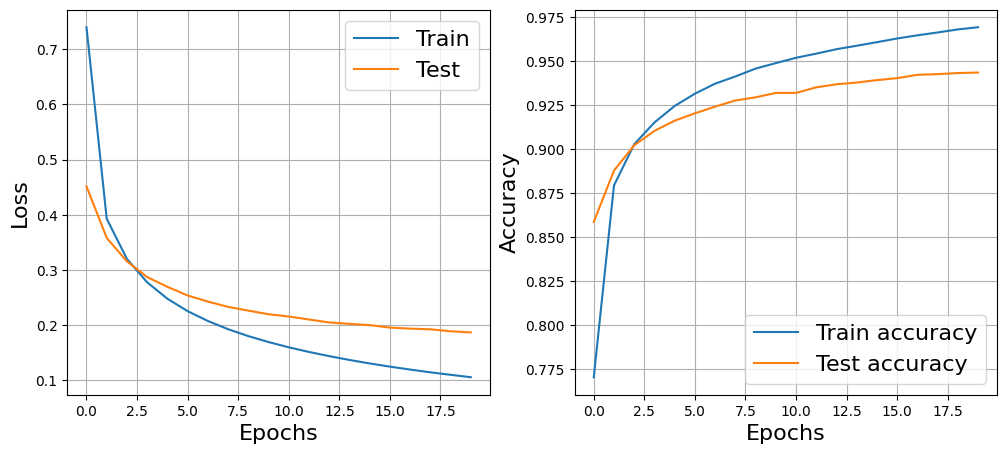

In [ ]:
networkTanh = NeuralNetwork([Linear(784, 100), Tanh(),
                             Linear(100, 100), Tanh(),
                             Linear(100, 10)])
tr_n_t, ts_n_t, tr_n_ac_t, ts_n_ac_t = train(networkTanh, 20, 0.01, plot=True, verbose=True, loss=NLLLoss())

###Сложение изображений с некоторым коэффициентом (аналог шума)

Думаю, что для этой задачи можно ради интереса попробовать метод аугментации, который подразумевает складывание картинок с некоторым коэффициентом. Это как бы аналог шума, но не белый шум.

Визуализация сложения (чтобы не было никаких случайных перекрытий и искажений, то мне кажется, что оптимально выбрать коэффициент сложения 0.075 и к текущему прибавить 5 следующих изображений):

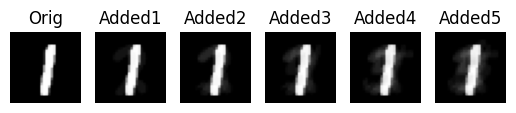

In [ ]:
def AddImage(image, imgToAdd, alpha=0.075):
  return image + alpha*imgToAdd

tempImg = img
mixingCounter = 5
plt.subplot(1, mixingCounter + 1, 1)
plt.imshow(tempImg, cmap=plt.cm.Greys_r)
plt.title("Orig")
plt.axis("off")

for i in range(mixingCounter):
  tempImg = AddImage(tempImg, X[i+1].reshape(28, 28))
  plt.subplot(1, mixingCounter + 1, i+2)
  plt.imshow(tempImg, cmap=plt.cm.Greys_r)
  plt.title(f"Added{i+1}")
  plt.axis("off")#153

Добавление сложенных изображений к датасету:

In [ ]:
mixedXYTr = (empty_like(tplXYTr[0]), tplXYTr[1])

trDatasetSize = mixedXYTr[0].shape[0]
alpha = 0.075

for i in range(trDatasetSize):
  mixedXYTr[0][i] = tplXYTr[0][i]
  for j in range(1, 6):
    mixedXYTr[0][i] += alpha*tplXYTr[0][(i + j)%trDatasetSize]

XTrWthMix = cat((tplXYTr[0], mixedXYTr[0]), 0)
YTrWthMix = cat((tplXYTr[1], mixedXYTr[1]), 0)

train_datasetMixed = TensorDataset(XTrWthMix, YTrWthMix)
train_loader = DataLoader(train_datasetMixed, batch_size=32, shuffle=True)

Обучаемся на датасете с добавлением только сложенных изображений:

Epoch 19... (Train/Test) NLL: 0.104/0.197	Accuracy: 0.970/0.943

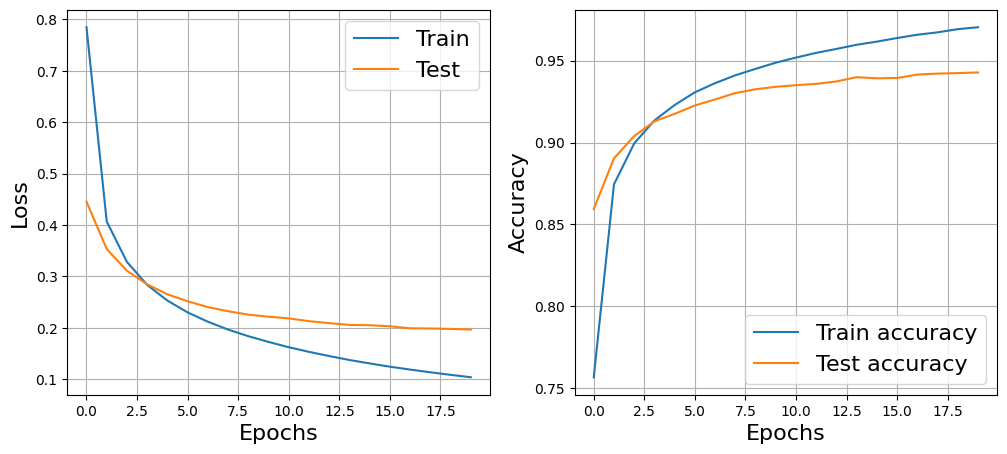

In [ ]:
networkTanh = NeuralNetwork([Linear(784, 100), Tanh(),
                             Linear(100, 100), Tanh(),
                             Linear(100, 10)])
tr_mix_t, ts_mix_t, tr_mix_ac_t, ts_mix_ac_t = train(networkTanh, 20, 0.01, plot=True, verbose=True, loss=NLLLoss())

###Вращения на ±15 градусов + случайные сдвиги + шум + сложение изображений

Добавление к исходному датасету всех аугментаций, которые применялись ранее (вращения на ±15 градусов, случайные сдвиги, шум):

In [ ]:
XTrWthAllAugs = cat((tplXYTr[0], Rotated15XYTr[0], Rotated_15XYTr[0],
                     shiftedXYTr[0], noisedXYTr[0], mixedXYTr[0]))
YTrWthAllAugs = cat((tplXYTr[1], Rotated15XYTr[1], Rotated_15XYTr[1],
                     shiftedXYTr[1], noisedXYTr[1], mixedXYTr[1]))

train_datasetWthAllAugs = TensorDataset(XTrWthAllAugs, YTrWthAllAugs)

train_loader = DataLoader(train_datasetWthAllAugs, batch_size=32, shuffle=True)

Обучаемся на датасете со всеми использованными выше аугментациями:

Epoch 19... (Train/Test) NLL: 0.125/0.118	Accuracy: 0.961/0.964

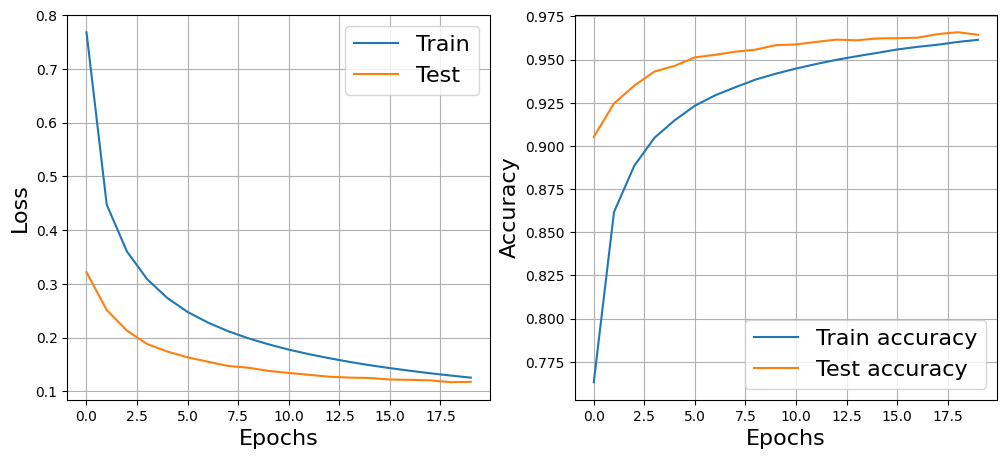

In [ ]:
networkTanh = NeuralNetwork([Linear(784, 100), Tanh(),
                             Linear(100, 100), Tanh(),
                             Linear(100, 10)])
tr_all_t, ts_all_t, tr_nall_ac_t, ts_all_ac_t = train(networkTanh, 20, 0.01, plot=True, verbose=True, loss=NLLLoss())#123

###Сравнение темпов обучения без аугментаций с темпами обучения при добавлении аугментаций:

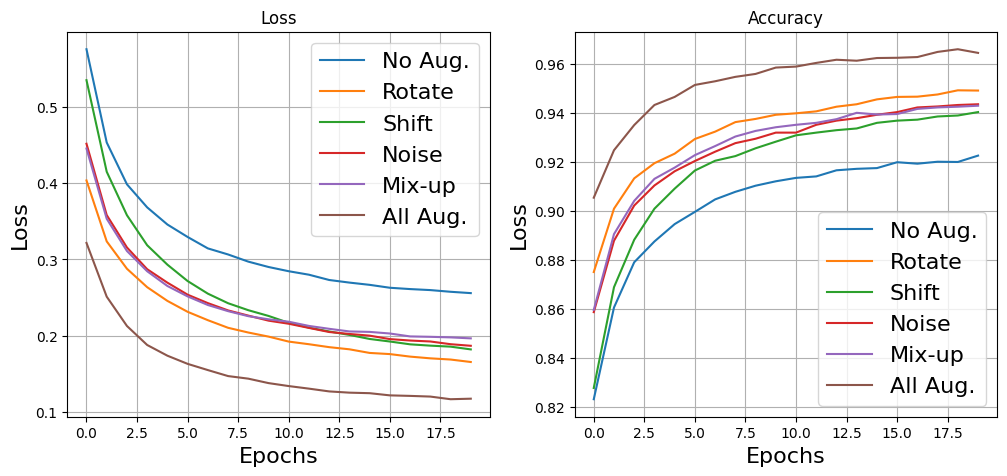

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_t, label='No Aug.')
plt.plot(ts_rot_t, label='Rotate')
plt.plot(ts_shft_t, label='Shift')
plt.plot(ts_n_t, label='Noise')
plt.plot(ts_mix_t, label='Mix-up')
plt.plot(ts_all_t, label='All Aug.')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_t, label='No Aug.')
plt.plot(ts_rot_ac_t, label='Rotate')
plt.plot(ts_shft_ac_t, label='Shift')
plt.plot(ts_n_ac_t, label='Noise')
plt.plot(ts_mix_ac_t, label='Mix-up')
plt.plot(ts_all_ac_t, label='All Aug.')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

Таким образом:

1) Получены результаты с использованием разных функций активации при обучении на одном и том же датасете. Наилучшим образом показали себя функции активации ReLU и ELU, наихудшим - сигмоида и гиперболический тангенс.

2) Были обучены нейросети с использованием одной и той же функции активации Tanh на модифицированных датасетах с добавлением различных аугментаций. Графическая иллюстрация сходимости при добавлении каждого типа аугментации была получена, так же было произведено сравнение эффективности каждой аугментации. Как отдельная аугментация наилучшим образом себя показала Rotate-аугментация. Наихудшим - Shift-аугментация. Комбинированное добавление к датасету всех аугментаций привело к тому, что сходимость на суммарном датасете повысилась. Но очевидно, что из-за этого пострадало время обучения, так как мощность обучающих датасетов возросла в разы.

То есть можно сделать выводы, что аугментация показала себя с хорошей стороны. Как и ожидалось, итоговый скор хорошо улучшился. Но многие советуют ей сильно не увлекаться, так как есть риск искажения данных.